# 📘 preprocessing_v2.ipynb

구성:
1. **make_monthly**: `seq`를 통합한 월별 집계 생성 + 전/후 월별 value 비교 시각화  
2. **log_norm**: `value`, `weight` 로그 변환 및 단가 계산 + 분포 비교 시각화  
3. **feature_engineering**: 시계열 lag / diff / rolling feature 생성 + 예시 item 시계열 시각화  
4. **pair_selection**: item 간 공행성(comovement) 후보쌍 추출 (동시 상관 기반 v1) + 상관계수 분포 시각화

## 0. 공통 설정 & 데이터 로드

In [39]:
import pandas as pd
import numpy as np
from pathlib import Path

import matplotlib.pyplot as plt
import seaborn as sns

plt.rcParams['font.family'] = 'NanumGothic'
plt.rcParams['axes.unicode_minus'] = False

# 이 노트북은 dacon/notebooks/2_Preprocessing/ 아래에 위치한다고 가정
PROJECT_ROOT = Path('/root/dacon')
DATA_DIR = PROJECT_ROOT / 'data' / 'raw'
TRAIN_PATH = DATA_DIR / 'train.csv'

train = pd.read_csv(TRAIN_PATH)
print('✅ train shape:', train.shape)
train.head()

✅ train shape: (10836, 9)


,item_id,year,month,seq,type,hs4,weight,quantity,value
0,DEWLVASR,2022,1,1.0,1,3038,14858.0,0.0,32688.0
1,ELQGMQWE,2022,1,1.0,1,2002,62195.0,0.0,110617.0
2,AHMDUILJ,2022,1,1.0,1,2102,18426.0,0.0,72766.0
3,XIPPENFQ,2022,1,1.0,1,2501,20426.0,0.0,11172.0
4,FTSVTTSR,2022,1,1.0,1,2529,248000.0,0.0,143004.0


## 1. make_monthly

**목표**
- `seq` 단위를 월별 level로 통합하여 시계열 분석이 가능한 형태로 변환
- `item_id, year, month` 기준으로 `value`, `weight`, `quantity` 집계
- 월별 `date`, `ym` 컬럼 생성
- item-level 메타 정보(예: `hs4`, `type`)를 합치기 위한 기초 작업

In [40]:
# 1-1. item 메타 정보 추출 (hs4, type)
#  - EDA 결과: 대부분 item_id별 hs4, type은 거의 고정이라고 가정하고 첫 값 사용
item_meta = (
    train[['item_id', 'hs4', 'type']]
    .drop_duplicates(subset=['item_id'])
    .set_index('item_id')
)
print('📦 item_meta shape:', item_meta.shape)
print(item_meta.head())

📦 item_meta shape: (100, 2)
           hs4  type
item_id             
DEWLVASR  3038     1
ELQGMQWE  2002     1
AHMDUILJ  2102     1
XIPPENFQ  2501     1
FTSVTTSR  2529     1


In [41]:
# 1-2. 월별 집계: seq 통합
agg_cols = ['value', 'weight', 'quantity']

df_month = (
    train
    .groupby(['item_id', 'year', 'month'], as_index=False)[agg_cols]
    .sum()
)

print('📦 df_month shape (집계 후):', df_month.shape)
print(df_month.head())

📦 df_month shape (집계 후): (3776, 6)
    item_id  year  month    value    weight  quantity
0  AANGBULD  2022      1  14276.0   17625.0       0.0
1  AANGBULD  2022      2  52347.0   67983.0       0.0
2  AANGBULD  2022      3  53549.0   69544.0       0.0
3  AANGBULD  2022      5  26997.0   34173.0       0.0
4  AANGBULD  2022      6  84489.0  103666.0       0.0


In [42]:
# 1-3. date, ym 컬럼 생성
df_month['date'] = pd.to_datetime(
    df_month['year'].astype(str)
    + '-'
    + df_month['month'].astype(str).str.zfill(2)
    + '-01'
)
df_month['ym'] = df_month['date'].dt.strftime('%Y-%m')

df_month = df_month.sort_values(['item_id', 'date']).reset_index(drop=True)

# 1-4. item_meta와 조인 (hs4, type 부여)
df_month = df_month.merge(item_meta, on='item_id', how='left')

# 형 변환 (hs4는 문자열, type은 category)
df_month['hs4'] = df_month['hs4'].astype(str)
df_month['type'] = df_month['type'].astype('category')

print('🔎 df_month dtypes:\n', df_month.dtypes)
print(df_month.head())

🔎 df_month dtypes:
 item_id             object
year                 int64
month                int64
value              float64
weight             float64
quantity           float64
date        datetime64[ns]
ym                  object
hs4                 object
type              category
dtype: object
    item_id  year  month    value    weight  quantity       date       ym  \
0  AANGBULD  2022      1  14276.0   17625.0       0.0 2022-01-01  2022-01   
1  AANGBULD  2022      2  52347.0   67983.0       0.0 2022-02-01  2022-02   
2  AANGBULD  2022      3  53549.0   69544.0       0.0 2022-03-01  2022-03   
3  AANGBULD  2022      5  26997.0   34173.0       0.0 2022-05-01  2022-05   
4  AANGBULD  2022      6  84489.0  103666.0       0.0 2022-06-01  2022-06   

    hs4 type  
0  4810    1  
1  4810    1  
2  4810    1  
3  4810    1  
4  4810    1  


### 1-E. EDA: 월별 집계 전/후 비교

- 원본 `train`과 월별 집계 후 `df_month`의 **월별 value 합계**가 동일한지 확인  
- 전처리 과정에서 **정보 손실 또는 집계 오류 여부**를 시각적으로 점검

📊 월별 value 합계 비교 (원본 vs 집계 후) 상위 5개:
            value_raw    value_agg
ym                               
2022-01  696534744.0  696534744.0
2022-02  538911879.0  538911879.0
2022-03  607177801.0  607177801.0
2022-04  591170783.0  591170783.0
2022-05  626300913.0  626300913.0


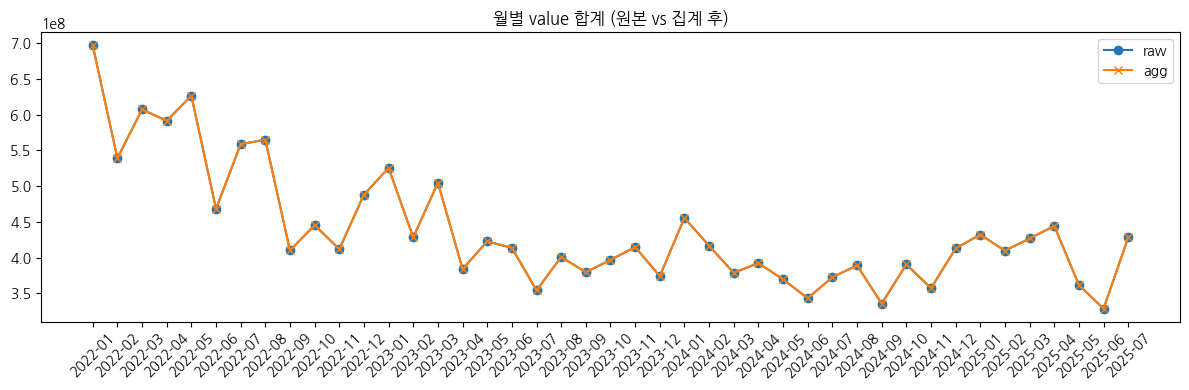

✅ make_monthly 단계 EDA 완료 (월별 합계 일치 여부 확인)


In [43]:
# 원본: 월별 value 합계
train['ym'] = train['year'].astype(str) + '-' + train['month'].astype(str).str.zfill(2)
monthly_raw = train.groupby('ym')['value'].sum().rename('value_raw')

# 집계 후: 월별 value 합계
monthly_agg = df_month.groupby('ym')['value'].sum().rename('value_agg')

monthly_compare = pd.concat([monthly_raw, monthly_agg], axis=1)

print('📊 월별 value 합계 비교 (원본 vs 집계 후) 상위 5개:\n', monthly_compare.head())

plt.figure(figsize=(12, 4))
plt.plot(monthly_compare.index, monthly_compare['value_raw'], label='raw', marker='o')
plt.plot(monthly_compare.index, monthly_compare['value_agg'], label='agg', marker='x')
plt.xticks(rotation=45)
plt.title('월별 value 합계 (원본 vs 집계 후)')
plt.legend()
plt.tight_layout()
plt.show()

print('✅ make_monthly 단계 EDA 완료 (월별 합계 일치 여부 확인)')

## 2. log_norm.ipynb

**목표**
- 분포가 치우친 `value`, `weight`에 대해 로그 변환
- 단가(`value_per_kg`) 계산
- 이후 표준화 및 공행성 분석(pair_selection)을 위한 기초 작업

In [44]:
# 2-1. 로그 변환 (log1p)
df_month['value_log'] = np.log1p(df_month['value'])
df_month['weight_log'] = np.log1p(df_month['weight'])

# 2-2. 단가 (kg당 value) 계산: weight가 0인 경우 NaN 처리
df_month['value_per_kg'] = df_month['value'] / df_month['weight'].replace(0, np.nan)

print('✅ log_norm 컬럼 생성 완료 (value_log, weight_log, value_per_kg)')
df_month[['item_id', 'ym', 'value', 'value_log', 'weight', 'weight_log', 'value_per_kg']].head()

✅ log_norm 컬럼 생성 완료 (value_log, weight_log, value_per_kg)


,item_id,ym,value,value_log,weight,weight_log,value_per_kg
0,AANGBULD,2022-01,14276.0,9.566405,17625.0,9.777130,0.809986
1,AANGBULD,2022-02,52347.0,10.865669,67983.0,11.127028,0.770001
2,AANGBULD,2022-03,53549.0,10.888371,69544.0,11.149729,0.770002
3,AANGBULD,2022-05,26997.0,10.203518,34173.0,10.439220,0.790010
4,AANGBULD,2022-06,84489.0,11.344388,103666.0,11.548939,0.815012


### 2-E. EDA: 로그 변환 전/후 분포 비교

- `value`와 `value_log`의 분포를 비교하여 **극단값 완화 효과** 확인  
- `weight`와 `weight_log`도 동일하게 비교

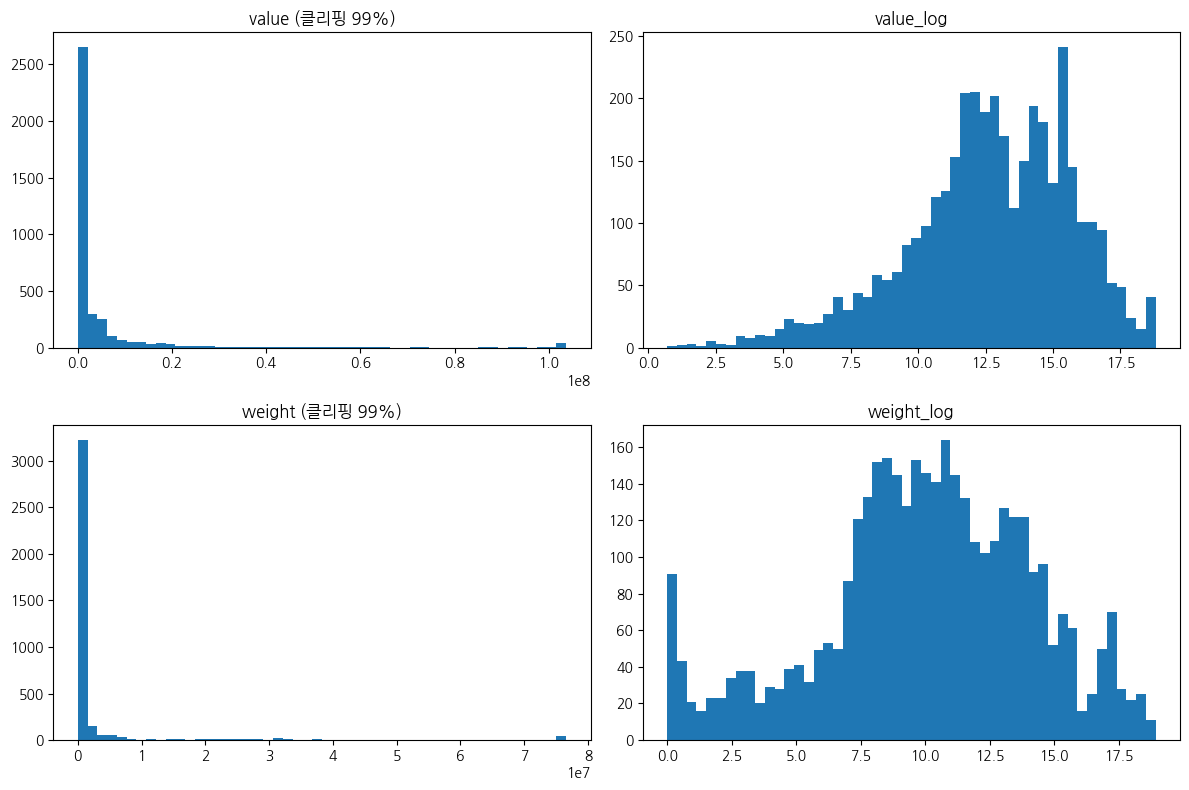

📊 로그 변환 전/후 분포 비교 시각화 완료


In [45]:
sample = df_month.sample(min(len(df_month), 5000), random_state=42)

fig, axes = plt.subplots(2, 2, figsize=(12, 8))

axes[0, 0].hist(sample['value'].clip(upper=sample['value'].quantile(0.99)), bins=50)
axes[0, 0].set_title('value (클리핑 99%)')

axes[0, 1].hist(sample['value_log'], bins=50)
axes[0, 1].set_title('value_log')

axes[1, 0].hist(sample['weight'].clip(upper=sample['weight'].quantile(0.99)), bins=50)
axes[1, 0].set_title('weight (클리핑 99%)')

axes[1, 1].hist(sample['weight_log'], bins=50)
axes[1, 1].set_title('weight_log')

plt.tight_layout()
plt.show()

print('📊 로그 변환 전/후 분포 비교 시각화 완료')

## 3. feature_engineering.ipynb

**목표**
- 각 item의 시계열에 대해 다음 feature 생성  
  - `value_lag_1`, `value_lag_2`  
  - `value_diff_1` (전월 대비 증감)  
  - `value_pct_change_1` (전월 대비 증감률)  
  - `value_roll_mean_3` (3개월 이동 평균)  
- 추후 LightGBM 등 회귀 모델 입력으로 활용 가능

In [46]:
def make_time_features(df_item: pd.DataFrame, max_lag: int = 2) -> pd.DataFrame:
    """단일 item_id에 대한 시계열 feature 생성."""
    df_item = df_item.sort_values('date').copy()

    for lag in range(1, max_lag + 1):
        df_item[f'value_lag_{lag}'] = df_item['value'].shift(lag)

    df_item['value_diff_1'] = df_item['value'] - df_item['value'].shift(1)
    df_item['value_pct_change_1'] = df_item['value'].pct_change(1)
    df_item['value_roll_mean_3'] = df_item['value'].rolling(3).mean()

    return df_item

def add_time_features_all_items(df_month: pd.DataFrame, max_lag: int = 2) -> pd.DataFrame:
    dfs = []
    for item_id, group in df_month.groupby('item_id'):
        dfs.append(make_time_features(group, max_lag=max_lag))
    out = pd.concat(dfs, axis=0).reset_index(drop=True)
    return out

df_feat = add_time_features_all_items(df_month, max_lag=2)
print('✅ df_feat shape:', df_feat.shape)
df_feat.head()

✅ df_feat shape: (3776, 18)


,item_id,year,month,value,weight,quantity,date,ym,hs4,type,value_log,weight_log,value_per_kg,value_lag_1,value_lag_2,value_diff_1,value_pct_change_1,value_roll_mean_3
0,AANGBULD,2022,1,14276.0,17625.0,0.0,2022-01-01,2022-01,4810,1,9.566405,9.777130,0.809986,NaN,NaN,NaN,NaN,NaN
1,AANGBULD,2022,2,52347.0,67983.0,0.0,2022-02-01,2022-02,4810,1,10.865669,11.127028,0.770001,14276.0,NaN,38071.0,2.666783,NaN
2,AANGBULD,2022,3,53549.0,69544.0,0.0,2022-03-01,2022-03,4810,1,10.888371,11.149729,0.770002,52347.0,14276.0,1202.0,0.022962,40057.333333
3,AANGBULD,2022,5,26997.0,34173.0,0.0,2022-05-01,2022-05,4810,1,10.203518,10.439220,0.790010,53549.0,52347.0,-26552.0,-0.495845,44297.666667
4,AANGBULD,2022,6,84489.0,103666.0,0.0,2022-06-01,2022-06,4810,1,11.344388,11.548939,0.815012,26997.0,53549.0,57492.0,2.129570,55011.666667


### 3-E. EDA: 예시 item의 시계열 feature 시각화

- 한 개의 예시 `item_id`를 선택하여:  
  - 원본 `value`  
  - `value_roll_mean_3`  
  를 함께 시각화하여 feature가 어떻게 생성되었는지 확인

🔍 예시 item_id: AANGBULD


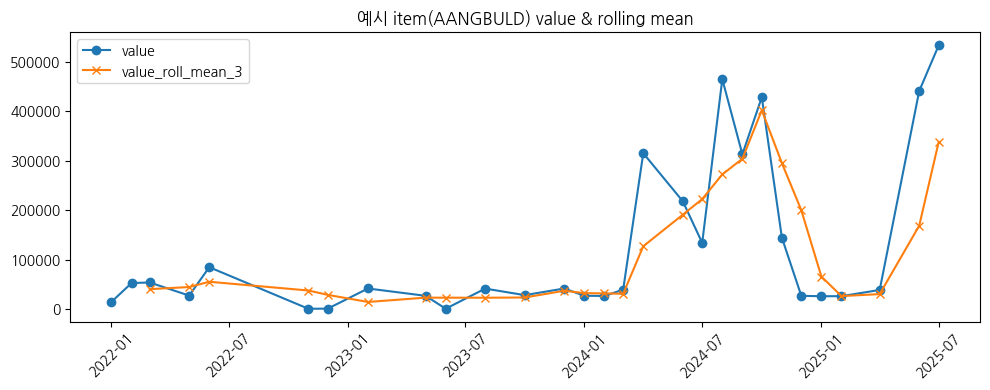

📈 예시 item 시계열 feature 시각화 완료


In [47]:
example_id = df_feat['item_id'].iloc[0]
df_example = df_feat[df_feat['item_id'] == example_id].sort_values('date')

print('🔍 예시 item_id:', example_id)

plt.figure(figsize=(10, 4))
plt.plot(df_example['date'], df_example['value'], label='value', marker='o')
plt.plot(df_example['date'], df_example['value_roll_mean_3'], label='value_roll_mean_3', marker='x')
plt.xticks(rotation=45)
plt.title(f'예시 item({example_id}) value & rolling mean')
plt.legend()
plt.tight_layout()
plt.show()

print('📈 예시 item 시계열 feature 시각화 완료')

## 4. pair_selection.ipynb

**목표 (v1 버전)**
- EDA 결과를 반영하여 **item 간 공행성(comovement) 후보쌍**을 추출  
- v1에서는 **동일 시점 기준 Z-score 값 상관계수**를 사용 (lag 미적용, 단순 베이스라인)  
- 추후 v2에서 lag correlation, 방향성(leading/following)까지 확장 예정  

### v1 설계
1. `item_id × ym` 형태로 value 피벗 (`pivot_value`)  
2. 로그 변환 후 item별 Z-score 표준화 (`pivot_std`)  
3. 관측치 개수가 일정 이상인 item만 사용 (예: 12개월 이상)  
4. 표준화된 값 기준 item 간 상관행렬 계산  
5. 상관계수 threshold(예: 0.5) 이상인 상삼각 원소만 추출 → 후보쌍

In [48]:
# 4-1. pivot 구성: item_id × ym
pivot_value = df_month.pivot_table(
    index='item_id',
    columns='ym',
    values='value',
    aggfunc='sum'
).sort_index(axis=1)

print('📐 pivot_value shape:', pivot_value.shape)
pivot_value.head()

📐 pivot_value shape: (100, 43)


ym,2022-01,2022-02,2022-03,2022-04,2022-05,2022-06,2022-07,2022-08,2022-09,2022-10,...,2024-10,2024-11,2024-12,2025-01,2025-02,2025-03,2025-04,2025-05,2025-06,2025-07
item_id,,,,,,,,,,,,,,,,,,,,,
AANGBULD,14276.0,52347.0,53549.0,NaN,26997.0,84489.0,NaN,NaN,NaN,NaN,...,428725.0,144248.0,26507.0,25691.0,25805.0,NaN,38441.0,NaN,441275.0,533478.0
AHMDUILJ,242705.0,120847.0,197317.0,126142.0,71730.0,149138.0,186617.0,169995.0,140547.0,89292.0,...,123085.0,143451.0,78649.0,125098.0,80404.0,157401.0,115509.0,127473.0,89479.0,101317.0
ANWUJOKX,NaN,NaN,NaN,63580.0,81670.0,26424.0,8470.0,NaN,NaN,80475.0,...,NaN,NaN,NaN,27980.0,NaN,NaN,NaN,NaN,NaN,NaN
APQGTRMF,383999.0,512813.0,217064.0,470398.0,539873.0,582317.0,759980.0,216019.0,537693.0,205326.0,...,683581.0,2147.0,NaN,25013.0,77.0,20741.0,2403.0,3543.0,32430.0,40608.0
ATLDMDBO,143097177.0,103568323.0,118403737.0,121873741.0,115024617.0,65716075.0,146216818.0,97552978.0,72341427.0,87454167.0,...,60276050.0,30160198.0,42613728.0,64451013.0,38667429.0,29354408.0,42450439.0,37136720.0,32181798.0,57090235.0


In [49]:
# 4-2. 로그 변환 및 item별 Z-score 표준화
pivot_log = np.log1p(pivot_value)

# 평균/표준편차 계산 (axis=1: 각 row(item) 기준)
row_means = pivot_log.mean(axis=1)
row_stds = pivot_log.std(axis=1).replace(0, np.nan)

pivot_std = pivot_log.sub(row_means, axis=0).div(row_stds, axis=0)

pivot_std.head()

ym,2022-01,2022-02,2022-03,2022-04,2022-05,2022-06,2022-07,2022-08,2022-09,2022-10,...,2024-10,2024-11,2024-12,2025-01,2025-02,2025-03,2025-04,2025-05,2025-06,2025-07
item_id,,,,,,,,,,,,,,,,,,,,,
AANGBULD,-0.550792,0.115966,0.127616,NaN,-0.223837,0.361636,NaN,NaN,NaN,NaN,...,1.195136,0.636140,-0.233237,-0.249283,-0.247010,NaN,-0.042486,NaN,1.209943,1.307318
AHMDUILJ,1.680203,0.071205,1.202490,0.170153,-1.132366,0.556558,1.073845,0.858589,0.419660,-0.627042,...,0.113545,0.466850,-0.919889,0.150976,-0.868967,0.680983,-0.033036,0.194372,-0.622215,-0.335522
ANWUJOKX,NaN,NaN,NaN,0.778553,1.111840,-0.390160,-1.904505,NaN,NaN,1.092220,...,NaN,NaN,NaN,-0.314001,NaN,NaN,NaN,NaN,NaN,NaN
APQGTRMF,0.597464,0.745866,0.304815,0.701576,0.772246,0.811072,0.947677,0.302339,0.770171,0.276295,...,0.893324,-2.063106,NaN,-0.803697,-3.764064,-0.899772,-2.005342,-1.806228,-0.670476,-0.555111
ATLDMDBO,1.974500,1.335708,1.600218,1.657293,1.543008,0.436897,2.017113,1.217478,0.626688,1.001551,...,0.266162,-1.101970,-0.418996,0.398489,-0.611011,-1.155478,-0.426581,-0.690820,-0.973778,0.158868


In [50]:
# 4-3. 최소 시계열 길이 기준 필터링
min_len = 12  # 최소 12개월 이상 데이터가 있는 item만 사용 (필요시 조정)

valid_counts = pivot_value.notna().sum(axis=1)
valid_items = valid_counts[valid_counts >= min_len].index

pivot_std_valid = pivot_std.loc[valid_items]
print('📌 유효 item 수 (min_len=12):', len(valid_items))

📌 유효 item 수 (min_len=12): 91


In [51]:
# 4-4. item 간 상관계수 행렬 계산 (동시 상관, v1)

# pivot_std_valid: index=item_id, columns=ym
# → transpose 후 .corr()를 쓰면 item 간 상관행렬을 얻을 수 있음

corr_items = pivot_std_valid.T.corr()

# 축 이름을 명시적으로 부여
corr_items = corr_items.rename_axis(index='item_a', columns='item_b')

print('📐 corr_items shape:', corr_items.shape)
corr_items.iloc[:5, :5]

📐 corr_items shape: (91, 91)


item_b,AANGBULD,AHMDUILJ,APQGTRMF,ATLDMDBO,AXULOHBQ
item_a,,,,,
AANGBULD,1.000000,0.025670,-0.048757,-0.202600,-0.336305
AHMDUILJ,0.025670,1.000000,-0.040737,0.171217,-0.277649
APQGTRMF,-0.048757,-0.040737,1.000000,0.354260,0.048037
ATLDMDBO,-0.202600,0.171217,0.354260,1.000000,-0.162035
AXULOHBQ,-0.336305,-0.277649,0.048037,-0.162035,1.000000


In [52]:
# 4-5. 상삼각 부분만 추출하여 후보쌍 리스트 생성
import numpy as np

threshold = 0.5  # 공행성 후보로 볼 최소 상관계수 (필요시 조정)

mask = np.triu(np.ones(corr_items.shape), k=1).astype(bool)
corr_upper = corr_items.where(mask)

# stack() 후 바로 DataFrame으로 만들면서 이름 지정
pairs = (
    corr_upper
    .stack(dropna=True)        # (item_a, item_b) → corr
    .reset_index(name='corr')  # item_a, item_b, corr 컬럼 생성
)

# corr 기준 필터링
candidate_pairs = (
    pairs
    .query('corr >= @threshold')
    .sort_values('corr', ascending=False)
    .reset_index(drop=True)
)

print(f'🔗 후보쌍 개수 (corr >= {threshold:.2f}):', len(candidate_pairs))
candidate_pairs.head()

🔗 후보쌍 개수 (corr >= 0.50): 64


/tmp/ipykernel_1082851/868928917.py:11: FutureWarning: The previous implementation of stack is deprecated and will be removed in a future version of pandas. See the What's New notes for pandas 2.1.0 for details. Specify future_stack=True to adopt the new implementation and silence this warning.
  corr_upper


,item_a,item_b,corr
0,QRKRBYJL,SDWAYPIK,0.740727
1,DNMPSKTB,XUOIQPFL,0.699396
2,QVLMOEYE,SDWAYPIK,0.695905
3,GYHKIVQT,QVLMOEYE,0.687429
4,ATLDMDBO,QVLMOEYE,0.685555


### 4-E. EDA: item 간 상관계수 분포 시각화

- 전체 상관계수(상삼각) 분포를 히스토그램으로 확인  
- threshold=0.5 이상인 구간이 어느 정도 비중을 차지하는지 감각적으로 파악

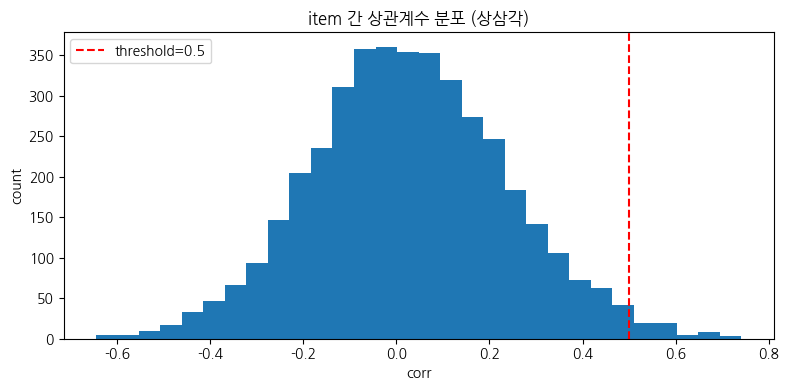

📊 item 간 상관계수 분포 시각화 완료


In [53]:
corr_values = pairs['corr']

plt.figure(figsize=(8, 4))
plt.hist(corr_values, bins=30)
plt.axvline(threshold, color='red', linestyle='--', label=f'threshold={threshold}')
plt.title('item 간 상관계수 분포 (상삼각)')
plt.xlabel('corr')
plt.ylabel('count')
plt.legend()
plt.tight_layout()
plt.show()

print('📊 item 간 상관계수 분포 시각화 완료')

In [54]:
# 4-6. 후보쌍 저장
OUTPUT_DIR = PROJECT_ROOT / 'data' / 'processed'
OUTPUT_DIR.mkdir(exist_ok=True)

pairs_path = OUTPUT_DIR / 'candidate_pairs_v1.csv'
candidate_pairs.to_csv(pairs_path, index=False)

print('💾 candidate_pairs_v1 저장 완료:', pairs_path)

💾 candidate_pairs_v1 저장 완료: /root/dacon/data/processed/candidate_pairs_v1.csv


## 5. 전처리 결과 저장 요약

- 월별 + 피처 포함 데이터프레임: `df_feat`  
- 공행성 후보쌍 목록: `candidate_pairs_v1.csv`

In [55]:
feat_path = OUTPUT_DIR / 'train_monthly_with_features_v1.parquet'
df_feat.to_parquet(feat_path, index=False)
print('💾 train_monthly_with_features_v1 저장 완료:', feat_path)

💾 train_monthly_with_features_v1 저장 완료: /root/dacon/data/processed/train_monthly_with_features_v1.parquet
